# Analiza časovne vrste podatkov Sentinel-2

Analizirali bomo časovno vrsto vegetacijskioh indeksov dobljenih iz podatkov satelita Sentinel-2

In [1]:
# Knjižnice
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Velikost grafikonov
plt.rcParams['figure.figsize'] = [10, 8]

In [4]:
# ID ključ mora biti definiran, preberemo ga iz datoteke
sentinelhub_id = 'sentinelhub.id'
f = open(sentinelhub_id,'r')
exec(f.readline())

In [5]:
if 'INSTANCE_ID' in locals():
    print("Sentinel Hub INSTANCE_ID obstaja")
    print(INSTANCE_ID)

Sentinel Hub INSTANCE_ID obstaja
f20f09f6-2bc3-46ed-8e96-438b69e367da


In [6]:
# Parametri za iskanje
shub_url_base="http://services.sentinel-hub.com/ogc/fis/"
# Ločljivost 10 m
res="&RESOLUTION=10m"
# Gledamo vse posnetke
maxcc="&MAXCC=100"

## Območje

Začnemo z enostavnim poligonom.

In [7]:
crs="EPSG:4326"
geometry_fn="podatki/kranj_rupa.wkt"

In [8]:
with open(geometry_fn, 'r') as geo_file:
  geometry = geo_file.read()
time = "2015-01-01/2018-12-31"

## Poizvedba

Preberemo celotno časovno vrsto.

In [9]:
# shub_url=shub_url_base+INSTANCE_ID+"?LAYER=VEGETATION_INDEX&STYLE=INDEX&CRS="+crs+"&TIME="+time+"&GEOMETRY="+geometry+res+maxcc
shub_url=shub_url_base+INSTANCE_ID+"?LAYER=NDVI-CLOUDS&STYLE=INDEX&CRS="+crs+"&TIME="+time+"&GEOMETRY="+geometry+res+maxcc
# shub_url = "http://services.sentinel-hub.com/ogc/fis/fe3a2277-a307-4ef0-b335-7f0145657768?LAYER=VEGETATION_INDEX&STYLE=INDEX&CRS=EPSG%3A3857&TIME=2015-01-01%2F2018-10-01&BBOX=1550369.86,5586056.25,1547498.69,5584861.92&RESOLUTION=10&MAXCC=5"
shub_url

'http://services.sentinel-hub.com/ogc/fis/f20f09f6-2bc3-46ed-8e96-438b69e367da?LAYER=NDVI-CLOUDS&STYLE=INDEX&CRS=EPSG:4326&TIME=2015-01-01/2018-12-31&GEOMETRY=POLYGON ((46.25707083080395 14.361464381217955, 46.25641802763134 14.361330270767212, 46.256362390637904 14.362172484397888, 46.25658864739251 14.362376332283022, 46.25699293992463 14.363197088241579, 46.25709679440581 14.362092018127441, 46.25707083080395 14.361464381217955))&RESOLUTION=10m&MAXCC=100'

## Prenos podatkov

Časovno vrsto prenesemo v obliki JSON.

In [10]:
r=requests.get(shub_url)
contents = json.loads(r.content.decode())

In [13]:
# Ustvarimo pandas dataframe
df = json_normalize(contents['C0'])
df.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,date
0,0.203662,0.140845,0.111700,0.018787,2018-06-30
1,0.061092,0.052540,0.045395,0.003385,2018-06-25
2,0.784255,0.688024,0.363063,0.121820,2018-06-20
3,0.363138,0.253455,0.172395,0.053041,2018-06-15
4,0.774577,0.693728,0.493108,0.049008,2018-06-10


In [14]:
# Dodamo še povprečno oblačnost v poligonu
df["clouds"] = json_normalize(contents['C1'])["basicStats.mean"]
df.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,date,clouds
0,0.203662,0.140845,0.111700,0.018787,2018-06-30,1.000000
1,0.061092,0.052540,0.045395,0.003385,2018-06-25,1.000000
2,0.784255,0.688024,0.363063,0.121820,2018-06-20,0.000000
3,0.363138,0.253455,0.172395,0.053041,2018-06-15,0.457518
4,0.774577,0.693728,0.493108,0.049008,2018-06-10,0.000000


In [15]:
# Stolpec date pretvorimo v datum in naredimo indeks
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index("date")
df.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,clouds
date,,,,,
2018-06-30,0.203662,0.140845,0.111700,0.018787,1.000000
2018-06-25,0.061092,0.052540,0.045395,0.003385,1.000000
2018-06-20,0.784255,0.688024,0.363063,0.121820,0.000000
2018-06-15,0.363138,0.253455,0.172395,0.053041,0.457518
2018-06-10,0.774577,0.693728,0.493108,0.049008,0.000000


In [19]:
# Podatke shranimo v datoteko
df_fn = "podatki/kranj_rupa.csv"
df.to_csv(df_fn)

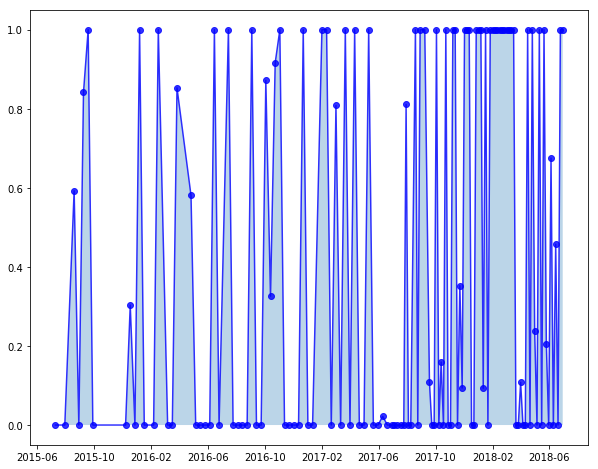

In [17]:
# Izrišemo graf oblačnosti
plt.plot(df["clouds"], linestyle='-', marker='o', color="b", alpha=0.8)
plt.fill_between(df.index, df["clouds"], alpha=0.3)
plt.show()

## Maskiranje podatkov z oblaki

In [21]:
# Izločimo podatke z več kot 10% oblakov
df = df.mask(df["clouds"] >= 0.1)
df.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,clouds
date,,,,,
2018-06-30,NaN,NaN,NaN,NaN,NaN
2018-06-25,NaN,NaN,NaN,NaN,NaN
2018-06-20,0.784255,0.688024,0.363063,0.121820,0.0
2018-06-15,NaN,NaN,NaN,NaN,NaN
2018-06-10,0.774577,0.693728,0.493108,0.049008,0.0


In [22]:
df.describe()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,clouds
count,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.631002,0.456045,0.300826,0.091710,0.003161
std,0.226260,0.229767,0.190951,0.066840,0.016285
min,0.037936,0.004727,-0.032019,0.005503,0.000000
25%,0.553032,0.281048,0.145021,0.036145,0.000000
50%,0.715336,0.472477,0.282091,0.063429,0.000000
75%,0.781458,0.675637,0.477146,0.150735,0.000000
max,0.843791,0.819808,0.668443,0.232010,0.093639


In [23]:
# Ustvarimo podatkovni sloj brez oblakov
df_cl = df.dropna()
df_cl.head()

,basicStats.max,basicStats.mean,basicStats.min,basicStats.stDev,clouds
date,,,,,
2018-06-20,0.784255,0.688024,0.363063,0.121820,0.0
2018-06-10,0.774577,0.693728,0.493108,0.049008,0.0
2018-05-31,0.684839,0.450683,0.362460,0.104486,0.0
2018-05-16,0.641694,0.363363,0.241323,0.148087,0.0
2018-05-06,0.769325,0.330141,0.189174,0.194542,0.0


## Graf poteka NDVI

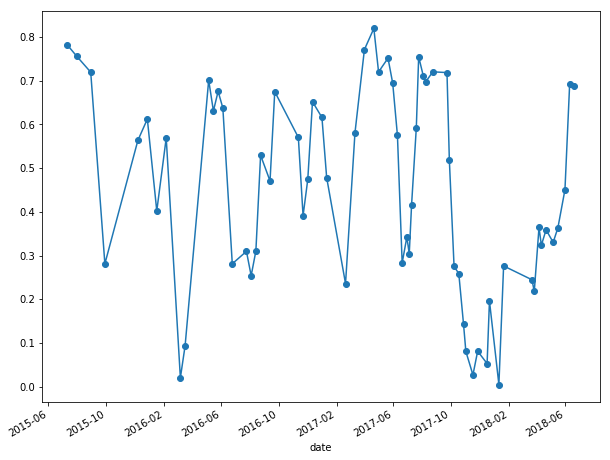

In [24]:
df_cl["basicStats.mean"].plot(linestyle='-', marker='o')

## Anliza podatkov za leto 2016

Poglejmo kako se je v letu 2016 razvijala vegetacija na različnih površinah. Zanima nas:

* gozd,
* njiva,
* naselje.